In [1]:
import sys
import os
import matplotlib.pyplot as plt
from pprint import pprint
import pickle

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src/")))


from src.pytorch_models import LightningRNNModule

from src.dataset import RuleBasedTasks
from torch.utils.data import DataLoader
from src.dataset import collate_fn

# Load models 
Models should be stored as a checkpoint folder with 
``` 
checkpoint_dir 
|- epoch_perf_.ckpt   # best performing model 
|- hp_pl_module.pkl   # model hyperparameters
|- last.ckpt          # final model after full training 
|- task_hp.pkl        # task hyperparameters 
``` 



In [2]:
checkpoint_dir = "saved_models/cernn/floral-yogurt-181_fdgo_s1_fdgo_v1_reactgo_s1_reactgo_v1_delaygo_s1_delaygo_v1_fdanti_s1_fdanti_v1_reactanti_s1_reactanti_v1_delayanti_s1_delayanti_v1_dmsgo_dmsnogo_dmcgo_dmcnogo_Sp_4_p-bfd_4_p_4"

with open(
    f"../{checkpoint_dir}/hp_pl_module.pkl",
    "rb",
) as file:
    hp_pl_module = pickle.load(file)

with open(
    f"../{checkpoint_dir}/task_hp.pkl",
    "rb",
) as file:
    task_hp = pickle.load(file)

# load last model by default
pretrained_model = LightningRNNModule.load_from_checkpoint(
    f"../{checkpoint_dir}/last.ckpt",
    strict=False  # ignores mismatched keys
)

{2: 4, 20: 4, 30: 4}
visual start 2 visual end 6
somatosensory start 23 somatosensory end 27
{2: 4, 20: 4, 30: 4}
{2: 4, 20: 4, 30: 4}


In [3]:
pretrained_model

LightningRNNModule(
  (loss_fnc): MSELoss()
  (model): CERNNModel(
    (rnn): RNNLayer(
      (rnncell): leaky_RNNCell_CERNN(
        (nonlinearity): Tanh()
      )
    )
    (readout): Linear(in_features=4, out_features=3, bias=False)
    (regularisers): ModuleList(
      (0): SE1()
      (1): SensoryActivityRegulariserL1()
      (2): IntraAreaPenalty()
      (3): SelfConnReg()
      (4): WiringEntropyRegulariser()
      (5): InputsSumToAvSpineCountGrad()
    )
  )
)

### Recurrent weight matrix 

In [4]:
recurrent_weights = pretrained_model.model.rnn.rnncell.weight_hh.detach().cpu().numpy()
recurrent_weights.shape

(52, 52)

## Regularisers with values

In [5]:
pprint(dict(hp_pl_module.regularisers))

{'SE': {'lambd': 1e-07, 'distance_matrix': 'resolve', 'ramping': False, 'dependency': 'linear', 'mode': 'L2'},
 'inputs_sum_to_av': {'lambd': 1e-06, 'duplicates': 'resolve', 'areas': 'resolve', 'species': 'mouse'},
 'intra_area_penalty': {'lambd': 1e-07, 'area_mask': 'resolve', 'penalty_type': 'L1'},
 'l1_sensory_activity_regulariser': {'lambd': 5e-08, 'sensory_indices': 'resolve'},
 'self_conn_reg': {'lambd': 1e-07, 'diag_mask': 'resolve'},
 'wiring_entropy_regulariser': {'lambd': 1e-08, 'distance_matrix': 'resolve'}}


# Cortical embedding object with CE info 
E.g. 
```
cortical_areas
duplicates 
distance_matrix
sensory and motor areas 
dmn_areas
```
and values used for this model



In [6]:
cortical_embeddign = pretrained_model.model.ce
vars(cortical_embeddign)

{'duplicates': {'VISp': 4, 'SSp-bfd': 4, 'MOp': 4},
 'mask_within_area_weights': False,
 'zero_weights_thres': 0.005,
 'cortical_areas': ['VISpl',
  'VISpor',
  'VISp',
  'RSPagl',
  'RSPd',
  'VISl',
  'PERI',
  'VISli',
  'ECT',
  'TEa',
  'VISpm',
  'RSPv',
  'AUDv',
  'AUDpo',
  'AUDp',
  'VISal',
  'VISrl',
  'AUDd',
  'SSs',
  'VISam',
  'SSp-bfd',
  'VISa',
  'VISC',
  'AIp',
  'SSp-tr',
  'SSp-un',
  'SSp-ul',
  'SSp-n',
  'SSp-ll',
  'MOs',
  'MOp',
  'ACAv',
  'ACAd',
  'GU',
  'SSp-m',
  'AIv',
  'AId',
  'ORBl',
  'ILA',
  'PL',
  'ORBvl',
  'ORBm',
  'FRP'],
 'original_distance_matrix': array([[0.        , 4.44676532, 1.69230804, ..., 4.17203265, 5.90109753,
         2.8487088 ],
        [4.44676532, 0.        , 3.05646444, ..., 1.64589234, 4.20153047,
         3.60108658],
        [1.69230804, 3.05646444, 0.        , ..., 3.30421185, 5.63259798,
         3.06588726],
        ...,
        [4.17203265, 1.64589234, 3.30421185, ..., 0.        , 2.70124514,
         2.71658194

## Corresponding dataset and dataloader
This is useful for activity analysis but not for connectivity

Input dimension is 2 rings x 2 dims per ring + 26 task IDs + 1 fixation = 31 

Ouput dimension is 2 dims per ring + 1 fixation = 3 

In [7]:
dataset_test = RuleBasedTasks(task_hp, mode="test")

dataloader_test = DataLoader(
    dataset_test,
    batch_size=1,  # batch size 1 here because we need all trials in batch to be same task/rule
    collate_fn=collate_fn,
    num_workers=0,
    shuffle=True,
)

In [8]:
trail_batch = next(iter(dataloader_test))

In [9]:
x = trail_batch.x.squeeze(0)
y = trail_batch.y.squeeze(0)

print(x.shape)  # [Timesteps, batchsize, D_in]
print(y.shape)  # [Timesteps, batchsize, D_out]

torch.Size([100, 40, 21])
torch.Size([100, 40, 3])


# Analysis 

In [10]:
from src.analysis_connectivity import (
    fig_3_plot_connectivity_matrix,
    fig_3_weights_over_distance_lambda_fitted,
    fig_3_FLN_matrix,
)

Density: 93.97%
Spearman correlation: 0.009620150927260126, p-value: 0.6278832257192732
Fitted exponential parameters: a=0.1509576047291807, lambda=0.00842285967077251


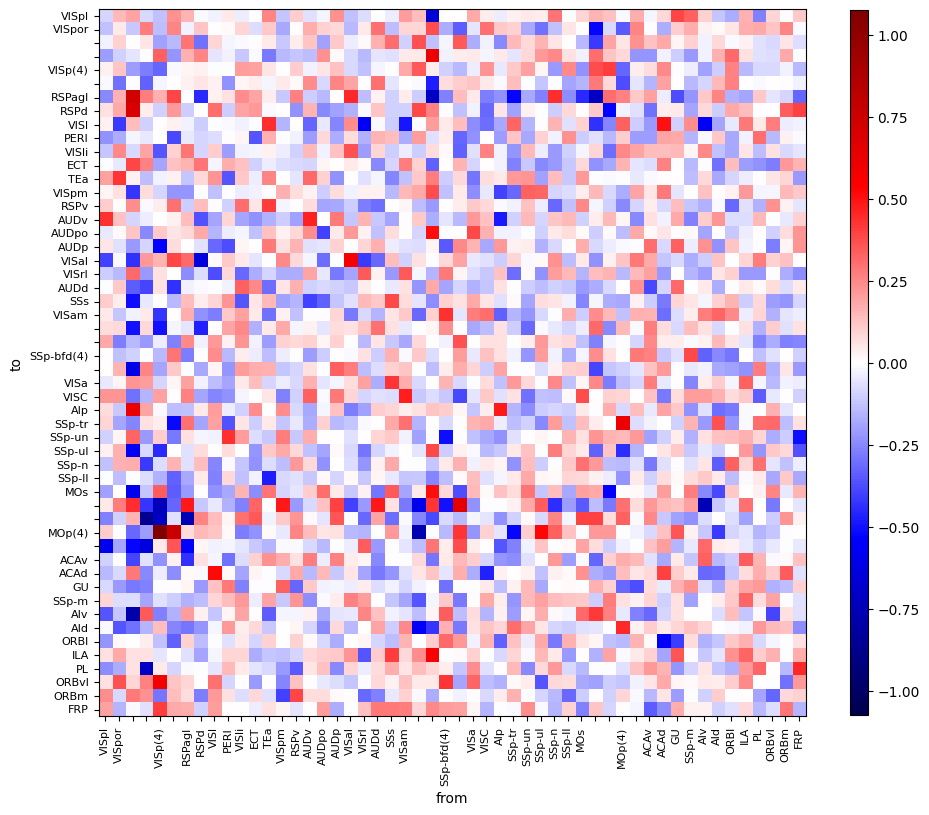

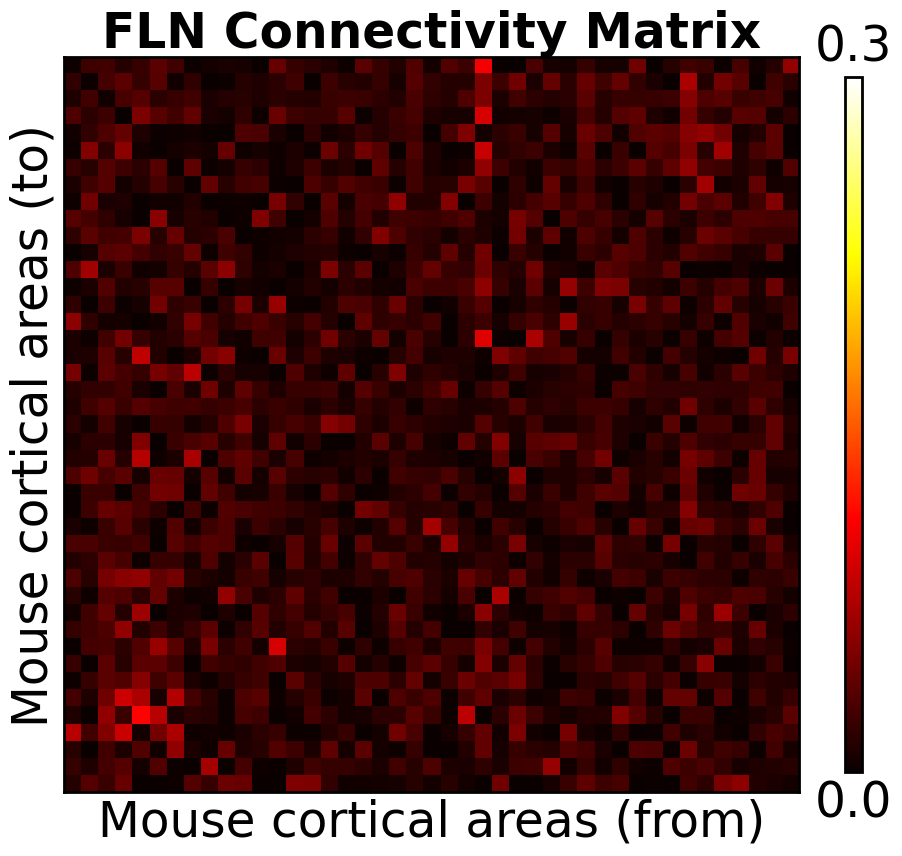

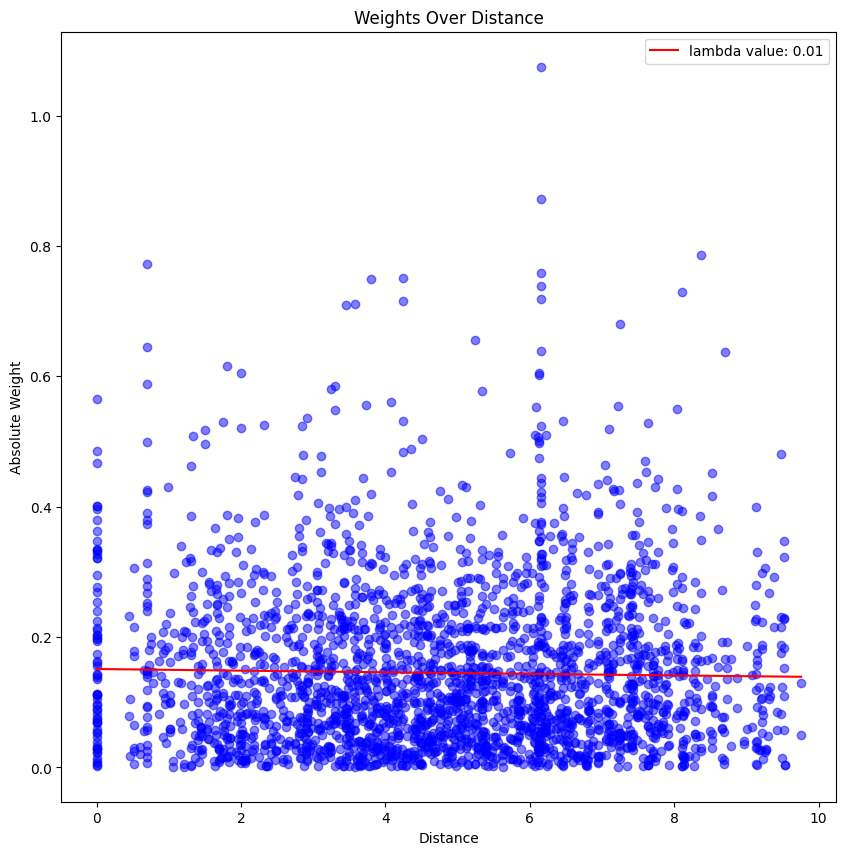

In [11]:
fig1 = fig_3_plot_connectivity_matrix(pretrained_model.model)
fig2 = fig_3_FLN_matrix(pretrained_model.model)
fig3 = fig_3_weights_over_distance_lambda_fitted(pretrained_model.model)